## Figure 2a: Comparison between Andrade Model and Maxwell Model

In [ ]:
import os
import matplotlib.colorbar as CB
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK
import numpy as NP
import numpy.linalg as NPL
import scipy.special as SSP
import sympy as SY
import sympy.matrices as SYM
import tool_layerallocation as LA
from matplotlib.legend_handler import HandlerTuple

def tidal_heat_production(EM_Distance, model, eta_LVZ=1e17):
    #-----------------------------#
    #Basic Parameters for the Moon#
    #Interior structures:#
    #A liquid core, 340 km#
    #A MIC layer, 300 km#
    #A lunar mantle, 1400 km#
    #-----------------------------#
    Angular_Velocity = 2 * NP.pi / ((EM_Distance/60)**(1.5)*29.530*24*60*60)## a~35 Re at 4.0 Ga, ~60 Re at present. According to Kepler'law, 
    Eccentricity = 0.0549## 4.0 Ga?
    G_Constant = 6.67e-11
    R_c = 340e3
    R_MIC = 640e3 
    R_mantle = 1695e3
    Rs = 1740e3
    Alpha = 0.5 
    Eta = [0.1, eta_LVZ, 1e20, 1e25] ##Eta[4] changed
    Vs = [0.1, 3500, 4500, 4500] ## Matsumoto et al. 2015
    Vp = [4000, 7000, 8000, 8000] ## Matsumoto et al. 2015
    Rho = [7800, 3440, 3400, 2800] 
    Mu = [x*y**2 for (x,y) in zip(Rho, Vs)]
    Kappa = [x*y**2 - 4*z/3 for (x,y,z) in zip(Rho, Vp, Mu)]
    Layer_Number = 101 ##Innermost layer: #0; Outermost layer: #100. We assume physical properties below are constant in any layer
    nr = [1, 41, 96, 101] ## Changed
    rr = [R_c, R_MIC, R_mantle, Rs]
    Radius = LA.Generation_radius(nr, rr)
    RADIUS = NP.array(Radius, dtype=complex).reshape(-1,1) ## RADIUS[0] is the top radius of Layer #0, i.e., the core, so do other layers. 
    GRAVITY = NP.zeros((Layer_Number,1), dtype=complex) ## GRAVITY is the gravitational acceleration of Layer #0, so do other layers.
    DENSITY = NP.zeros((Layer_Number,1), dtype=complex) ## DENSITY is the density of Layer #0, so do other layers.
    SHEAR_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    LAME_CONSTANT = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    BULK_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## still real number value in the viscoelastic problem
    mu_tmp = 0 ## used to calculate real/imaginary-number-value shear modulus
    sm_real = 0 ## real part of complex shear modulus
    sm_img = 0 ## imaginary part of complex shear modulus
    if model=='Maxwell':
        for layer, radius in enumerate(RADIUS):
            if radius.real <= Radius[0]:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    elif model=='Andrade':
        for layer, radius in enumerate(RADIUS):
            if radius <= R_c:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                SHEAR_MODULUS[layer] = 0 + 0j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                Beta = mu_tmp**(Alpha-1) / eta_tmp**(Alpha) ##3.2e-13
                andrade_cos = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.cos(Alpha*NP.pi/2)
                andrade_sin = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.sin(Alpha*NP.pi/2)
                sm_real = mu_tmp * (1+mu_tmp*andrade_cos) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                sm_img = mu_tmp**2 * (andrade_sin+1/(eta_tmp*Angular_Velocity)) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    #----------------------------------------------------------------------------#
    #Generating Propagator Matrix based on Sabadini, Vermeersen & Cambiotti, 2016#
    #----------------------------------------------------------------------------#
    pgYk = NP.zeros((Layer_Number,6,6), dtype=complex) ## The propagator matrix (type: ndarray), product of k=0 to N-1, do not calculate Layer 0. 
    r = SY.Symbol('r', complex=True)                  ## The shape of ndarray can be >= 3 while the shape of matrix must be 2. 
    g = SY.Symbol('g', complex=True)                  ## Every element of pgYk should be converted to matrix before involved  
    mu = SY.Symbol('mu', complex=True) ## complex number
    rho = SY.Symbol('rho', complex=True)
    Y = SYM.Matrix([[r**3 / 7, r, 0, 1 / (2*r**2), 1 / r**4, 0],
                [5 * r**3 / 42, r / 2, 0, 0, -1 / (3*r**4), 0],
                [(-mu + g*rho*r) *r**2 / 7, 2*mu + g*rho*r, r**2 * rho, (-6*mu + g*rho*r) / (2*r**3), (-8*mu + g*rho*r) / r**5, rho / r**3],
                [8*mu * r**2 / 21, mu, 0, mu / (2*r**3), 8*mu / (3*r**5), 0],
                [0, 0, r**2, 0, 0, 1 / r**3],
                [4*SY.pi*G_Constant*rho*r**3 / 7, 4*SY.pi*G_Constant*rho*r, 5*r, 2*SY.pi*G_Constant*rho / r**2, 4*SY.pi*G_Constant*rho / r**4, 0]])
    D = SYM.diag(3 / r**3, 1 / r, -1 / r, 2*r**2, 3*r**4 / 7, r**3) / 5
    Ybar = SYM.Matrix([[rho * g * r / mu - 8, 16, -r / mu, 2 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 6, -6, r / mu, 0, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho, 0, 0, 0, 0, -1],
                    [rho * g * r / mu + 2, 6, -r / mu, -3 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 1, -16, r / mu, 5 * r / mu, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho * r, 0, 0, 0, 5, -r]])
    invY = D * Ybar ## Y.inv() works, too
    func_Yk = SY.lambdify((r, g, mu, rho), Y, modules='numpy') ## Convert Sympy matrices into Numpy ndarrays (i.e., matrices)
    func_invYk = SY.lambdify((r, g, mu, rho), invY, modules='numpy') ## Ditto
    for k, ite_tmp in enumerate(RADIUS[1:], start=1): ##enumerate will return a tuple, which is immutable. So we directly change the pgYk via index
        if k == 1:
            pgYk[k] = func_invYk(complex(RADIUS[0]), complex(GRAVITY[1]), complex(SHEAR_MODULUS[1]), complex(DENSITY[1]))
            continue
        else:
            Yk_tmp = func_Yk(complex(RADIUS[k-1]), complex(GRAVITY[k-1]), complex(SHEAR_MODULUS[k-1]), complex(DENSITY[k-1]))
            invYk_tmp = func_invYk(complex(RADIUS[k-1]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
            pgYk[k] = invYk_tmp @ Yk_tmp @ pgYk[k-1] ## @ operator is matrix multiplication

    #--------------------------------------#
    #Calculating Interface Matrix#
    #CMB boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    Ic = NP.array([[-Radius[0]**2 / complex(GRAVITY[0]), 0, 1], 
                [0, 1, 0],
                [0, 0, complex(GRAVITY[0]) * complex(DENSITY[0])],
                [0, 0, 0],
                [Radius[0]**2, 0, 0],
                [2 * Radius[0], 0, 4 * NP.pi* G_Constant * complex(DENSITY[0])]], dtype=complex) 

    #--------------------------------------#
    #Solving Cc, the constant vector#
    #Surface boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    P1 = NP.diag(NP.array([0, 0, 1, 1, 0, 1], dtype=complex)) ##Selection Matrix
    Bs = NP.array([[0], [0], [5 / Radius[-1]]], dtype=complex) ##y3=0; y4=0; y6=5/Rs. ##test
    pgY = P1 @ func_Yk(complex(RADIUS[Layer_Number-1]), complex(GRAVITY[Layer_Number-1]), complex(SHEAR_MODULUS[Layer_Number-1]), complex(DENSITY[Layer_Number-1])) @ pgYk[Layer_Number-1] @ Ic
    Cc = NPL.solve(pgY[[2,3,5],:], Bs)

    #-----------------------------------------------------------------------------------------------------#
    #Calculating the vector y#
    #Note: the signs of y1-y4 obtained here are opposite to those in Tobie et al. (2005)#
    #This is because we define the outward radial direction as positive, i.e., tensile stress is positive#
    #while Tobie et al. (2005) consider the inward radia direction as positive, i.e., compress is positive#
    #NNote: In Tobie et al. (2005), y2 represented spheroidal radial stress#
    #and y3 represented spheroidal tangential displacement.#
    #-----------------------------------------------------------------------------------------------------#
    y1 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial displacement
    y2 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential displacement
    y3 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial stress
    y4 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential stress 
    y5 = NP.zeros((Layer_Number,1), dtype=complex) ## potential
    y6 = NP.zeros((Layer_Number,1), dtype=complex) ## potential stress
    for k, radius in enumerate(RADIUS):
        Yk = func_Yk(complex(RADIUS[k]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
        yk = Yk @ pgYk[k] @ Ic @ Cc
        y1[k] = yk[0]
        y2[k] = yk[1]
        y3[k] = yk[2]
        y4[k] = yk[3]
        y5[k] = yk[4]
        y6[k] = yk[5]

    #---------------------------------------------------------#
    #Calculate H_mu and tidal dissipation rate per unit volume#
    #This method works for computating the radial distribution#
    #of the dissipation rate within any planetary interior#
    #according to Kervazo et al., 2021; Tobie et al., 2005#
    #---------------------------------------------------------#
    y_1 = SY.Symbol('y_1', complex=True)
    y_2 = SY.Symbol('y_2', complex=True)
    y_3 = SY.Symbol('y_3', complex=True)
    y_4 = SY.Symbol('y_4', complex=True)
    kappa = SY.Symbol('kappa', complex=True)
    dy_1 = (y_2 - (kappa-2*mu/3)*(2*y_1-6*y_3)/r) / (kappa + 4*mu/3) 
    H_mu_part1 = 4/3 * (r/SY.Abs(kappa+4*mu/3))**2 * (SY.Abs(y_2 - (kappa-2*mu/3)*(2*y_1 - 6*y_3)/r))**2
    H_mu_part2 = -4/3 * r * (dy_1.conjugate()*(2*y_1 - 6*y_3)).as_real_imag()[0]
    H_mu_part3 = 1/3 * (SY.Abs(2*y_1 - 6*y_3))**2 
    H_mu_part4 = 6 * r**2 * (SY.Abs(y_4))**2 / (SY.Abs(mu))**2 
    H_mu_part5 = 24 * (SY.Abs(y_3))**2 
    H_mu = H_mu_part1 + H_mu_part2 + H_mu_part3 + H_mu_part4 + H_mu_part5
    func_Hmu = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r), H_mu, modules='numpy')

    #------------------------------------------------------------#
    #Calculating the tidal dissipation rate#
    #according to Eq. (37) in Tobie et al. (2005)#
    #Note: our y1-y4 are opposite to those of Tobie et al. (2005)#
    #and y2-y3 should exchange #
    #------------------------------------------------------------#
    Hmu = NP.zeros((Layer_Number,1)) 
    h_tide = NP.zeros((Layer_Number,1)) ## tidal dissipation rate, W/m^3
    Volume_MIC = 4/3 * NP.pi * (rr[1]**3 - rr[0]**3)
    Volume_mantle = 4/3 * NP.pi * (rr[2]**3 - rr[1]**3)
    Power_tide_MIC = 0
    Power_tide_mantle = 0
    for k, radius in enumerate(RADIUS):
        if radius.real <= rr[0]:
            continue
        elif radius.real <= rr[1]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_MIC = Power_tide_MIC + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        elif radius.real <= rr[2]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_mantle = Power_tide_mantle + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        else:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag

    return h_tide[:,0], RADIUS[:,0].real
    '''
    #-----------------------------------------------------#
    #Calculate strain tensor and stress tensor#
    #according to Kervazo et al., 2021; Tobie et al., 2005#
    #y_1 is spheroidal radial displacement#
    #y_3 is spheroidal tangential displacement#
    #y_2 is spheroidal radial stress#
    #y_4 is spheroidal tangential stress #
    #-----------------------------------------------------#
    theta = SY.Symbol('theta') ## colatitude
    phi = SY.Symbol('phi') ## longitude, sub-Jovian point is 0 longitude
    t = SY.Symbol('t') ## time
    y_1 = SY.Symbol('y_1')
    y_2 = SY.Symbol('y_2')
    y_3 = SY.Symbol('y_3')
    y_4 = SY.Symbol('y_4')
    kappa = SY.Symbol('kappa', complex=True)
    Tidal_Potential = (Rs**2 * Angular_Velocity**2 * Eccentricity
                    * ((-(3*SY.cos(theta)*SY.cos(theta)-1)*3/4) * SY.cos(Angular_Velocity*t) 
                        + (SY.sin(theta)*SY.sin(theta)*3/4) * (3*SY.cos(Angular_Velocity*t)*SY.cos(2*phi) + 4*SY.sin(Angular_Velocity*t)*SY.sin(2*phi))))
    dy_1 = (y_2 - (kappa-2*mu/3)*(2*y_1-6*y_3)/r) / (kappa + 4*mu/3) 
    #-----------------------------#
    #Calculating the strain tensor#
    #-----------------------------#
    Strain_rr = dy_1 * Tidal_Potential
    Strain_tt = (y_3*SY.diff(Tidal_Potential, theta, 2) + y_1*Tidal_Potential) / r
    Strain_pp = (y_3*SY.diff(Tidal_Potential, phi, 2)/SY.sin(theta)/SY.sin(theta) + y_3*SY.diff(Tidal_Potential, theta)/SY.tan(theta) + y_1*Tidal_Potential) / r
    Strain_tp = (SY.diff(SY.diff(Tidal_Potential, phi), theta) - SY.diff(Tidal_Potential, phi)/SY.tan(theta)) * y_3 / (r * SY.sin(theta))
    Strain_rp = y_4 * SY.diff(Tidal_Potential, phi) / (mu*SY.sin(theta)) / 2
    Strain_rt = y_4 * SY.diff(Tidal_Potential, theta) / mu / 2
    func_strainrr = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r, theta, phi, t), SY.simplify(Strain_rr), modules='numpy')
    func_straintt = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r, theta, phi, t), SY.simplify(Strain_tt), modules='numpy')
    func_strainpp = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r, theta, phi, t), SY.simplify(Strain_pp), modules='numpy')
    func_straintp = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r, theta, phi, t), SY.simplify(Strain_tp), modules='numpy')
    func_strainrp = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r, theta, phi, t), SY.simplify(Strain_rp), modules='numpy')
    func_strainrt = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r, theta, phi, t), SY.simplify(Strain_rt), modules='numpy')
    #---------------------------------------------------------------#
    #Construct the grid to calculate the tidal power.#
    #The regular grid in latitude and longitude is typically 2° × 2°#
    #according to Roberts & Nimmo, 2008#
    #---------------------------------------------------------------#
    Colatitude_Number = 91 ## node number in the theta-direction. colat[0]=0; colat[90]=pi
    Longitude_Number = 181 ## node number in the phi-direction. lon[0]=0; lon[180]=2*pi
    dTheta = NP.pi / (Colatitude_Number-1)
    dPhi = 2*NP.pi / (Longitude_Number-1)
    THETA = NP.linspace(0, NP.pi, Colatitude_Number)
    PHI = NP.linspace(0, 2*NP.pi, Longitude_Number)
    THETA_element = (THETA[:-1] + THETA[1:]) / 2
    PHI_element =  (PHI[:-1] + PHI[1:]) / 2
    TIME = NP.linspace(0, Period*7/8, 8) ##8 equispaced times over an orbital period

    Ptide_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1)) ## Ptide_element[0][:][:] excluded
    Strainrr_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1, 8), dtype=complex) 
    Straintt_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1, 8), dtype=complex) 
    Strainpp_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1, 8), dtype=complex) 
    Straintp_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1, 8), dtype=complex) 
    Strainrp_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1, 8), dtype=complex) 
    Strainrt_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1, 8), dtype=complex) 
    Strainrr_tmp = 0 + 0j
    Straintt_tmp = 0 + 0j
    Strainpp_tmp = 0 + 0j
    Straintp_tmp = 0 + 0j
    Strainrp_tmp = 0 + 0j
    Strainrt_tmp = 0 + 0j
    Stresshydro_tmp = 0 + 0j
    Stressrr_tmp = 0 + 0j
    Stresstt_tmp = 0 + 0j
    Stresspp_tmp = 0 + 0j
    Stresstp_tmp = 0 + 0j
    Stressrp_tmp = 0 + 0j
    Stressrt_tmp = 0 + 0j
    y1k = 0 + 0j
    y2k = 0 + 0j
    y3k = 0 + 0j
    y4k = 0 + 0j
    muk = 0 + 0j
    kappak = 0 + 0j
    Ptide_tmp = 0

    for k, radius in enumerate(RADIUS):
        if radius <= R_ic:
            continue
        else:
            print(k) ## debug
            y1k = complex(-y1[k]) ## spheroidal radial displacement
            y2k = complex(-y2[k]) ## spheroidal tangential displacement
            y3k = complex(-y3[k]) ## spheroidal radial stress
            y4k = complex(-y4[k]) ## spheroidal tangential stress 
            muk = complex(SHEAR_MODULUS[k])
            kappak = complex(BULK_MODULUS[k])

            for i, colat in enumerate(THETA_element):
                for j, lon in enumerate(PHI_element):
                    for l, time in enumerate(TIME): 
                        Strainrr_tmp = func_strainrr(y1k, y3k, y2k, y4k, 
                                                    muk, kappak, 
                                                    complex(radius), complex(colat), complex(lon), complex(time))
                        
                        Straintt_tmp = func_straintt(y1k, y3k, y2k, y4k, 
                                                    muk, kappak, 
                                                    complex(radius), complex(colat), complex(lon), complex(time))

                        Strainpp_tmp = func_strainpp(y1k, y3k, y2k, y4k, 
                                                    muk, kappak, 
                                                    complex(radius), complex(colat), complex(lon), complex(time))
                        
                        Straintp_tmp = func_straintp(y1k, y3k, y2k, y4k, 
                                                    muk, kappak, 
                                                    complex(radius), complex(colat), complex(lon), complex(time))
                        
                        Strainrt_tmp = func_strainrt(y1k, y3k, y2k, y4k, 
                                                    muk, kappak, 
                                                    complex(radius), complex(colat), complex(lon), complex(time))
                        
                        Strainrp_tmp = func_strainrp(y1k, y3k, y2k, y4k, 
                                                    muk, kappak, 
                                                    complex(radius), complex(colat), complex(lon), complex(time))
                        
                        Stresshydro_tmp = (kappak - 2/3*muk)*(Strainrr_tmp + Straintt_tmp + Strainpp_tmp)
                        Stressrr_tmp = 2*muk*Strainrr_tmp + Stresshydro_tmp
                        Stresstt_tmp = 2*muk*Straintt_tmp + Stresshydro_tmp
                        Stresspp_tmp = 2*muk*Strainpp_tmp + Stresshydro_tmp
                        Stresstp_tmp = 2*muk*Straintp_tmp
                        Stressrt_tmp = 2*muk*Strainrt_tmp
                        Stressrp_tmp = 2*muk*Strainrp_tmp

                        
                        Ptide_tmp = (Strainrr_tmp.real*Stressrr_tmp.imag - Strainrr_tmp.imag*Stressrr_tmp.real
                                    +Straintt_tmp.real*Stresstt_tmp.imag - Straintt_tmp.imag*Stresstt_tmp.real
                                    +Strainpp_tmp.real*Stresspp_tmp.imag - Strainpp_tmp.imag*Stresspp_tmp.real
                                    +2*(Straintp_tmp.real*Stresstp_tmp.imag - Straintp_tmp.imag*Stresstp_tmp.real)
                                    +2*(Strainrt_tmp.real*Stressrt_tmp.imag - Strainrt_tmp.imag*Stressrt_tmp.real)
                                    +2*(Strainrp_tmp.real*Stressrp_tmp.imag - Strainrp_tmp.imag*Stressrp_tmp.real)) *Angular_Velocity/2 
                        
                        Ptide_element[k][i][j] += Ptide_tmp/8
    #---------------------------------------------------------------------#
    #Calculate the horizontal averaged and volumetric averaged tidal power#
    #---------------------------------------------------------------------#     
    Area_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1)) ## Area_element[0][:][:] excluded
    Vol_element = NP.zeros((Layer_Number, Colatitude_Number-1, Longitude_Number-1)) ## Vol_element[0][:][:] excluded
    Ptide_have = NP.zeros((Layer_Number,1))
    Ptide_silave = 0
    for k, radius in enumerate(RADIUS):
        if radius <= R_ic:
            continue
        elif radius <=R_c:
            for i, colat in enumerate(THETA_element):
                for j, lon in enumerate(PHI_element):
                    Area_element[k][i][j] = radius.real**2 * dPhi * (NP.cos(colat - dTheta/2) - NP.cos(colat + dTheta/2))
                    Vol_element[k][i][j] = (radius.real**3 - RADIUS[k-1].real**3)/3 * dPhi * (NP.cos(colat - dTheta/2) - NP.cos(colat + dTheta/2))
                    Ptide_have[k] += Ptide_element[k][i][j] * Area_element[k][i][j]
                    Ptide_silave += Ptide_element[k][i][j] * Vol_element[k][i][j]
            
            Ptide_have[k] /= 4 * NP.pi * radius.real**2
        else:
            for i, colat in enumerate(THETA_element):
                for j, lon in enumerate(PHI_element):
                    Area_element[k][i][j] = radius.real**2 * dPhi * (NP.cos(colat - dTheta/2) - NP.cos(colat + dTheta/2))
                    Vol_element[k][i][j] = (radius.real**3 - RADIUS[k-1].real**3)/3 * dPhi * (NP.cos(colat - dTheta/2) - NP.cos(colat + dTheta/2))
                    Ptide_have[k] += Ptide_element[k][i][j] * Area_element[k][i][j]
    '''


PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext    
ticksize_ax = 30
labelsize_ax = 30
linewidth_ax = 2.5
borderwidth_ax = 3
textsize_ax = 30
legendsize_ax = 25
#plot#
fig,ax =PLT.subplots(figsize=(9,9))
EM_Distance = 35 ## normalized by Re
h_tide_Andrade, Radius = tidal_heat_production(EM_Distance, 'Andrade')
h_tide_Maxwell, tmp = tidal_heat_production(EM_Distance, 'Maxwell')
h_tide_Andrade_5e16, tmp = tidal_heat_production(EM_Distance, 'Andrade', 5e16)
h_tide_Maxwell_5e16, tmp = tidal_heat_production(EM_Distance, 'Maxwell', 5e16)
Andrade_1e17, = ax.plot(h_tide_Andrade, Radius/1e3, linewidth=linewidth_ax, color='olive', linestyle='-', label='Andrade') 
Maxwell_1e17, = ax.plot(h_tide_Maxwell, Radius/1e3, linewidth=linewidth_ax, color='black', linestyle='-', label='Maxwell') 
Radiogenic = ax.vlines(4e-8,340,1740,linestyle='-', color='orange', label='Radiogenic Power')
Radio_handle, = ax.plot([0.1,0.2], [0.1,0.2], linestyle='-', color='orange', label='Radiogenic Power')
print(h_tide_Andrade)
#axes setting#
ax.set_xscale('log')
ax.set_xlim(1.0e-12,1.0e-6)
ax.set_ylim(340,1740)
ax.xaxis.set_major_locator(TICK.LogLocator(base=10,numticks =11))
ax.xaxis.set_minor_locator(TICK.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks =11))
ax.xaxis.set_minor_formatter(TICK.NullFormatter())
ax.yaxis.set_major_locator(TICK.MultipleLocator(200))
ax.yaxis.set_minor_locator(TICK.MultipleLocator(20))
ax.set_xticks([1.0e-12,1.0e-10,1.0e-8,1.0e-6]) ##
ax.set_xticklabels([r"$10^{-12}$",r"$10^{-10}$",
                    r"$10^{-8}$",r"$10^{-6}$"]) ##
ax.set_ylabel("Radius (km)",fontsize=labelsize_ax) 
ax.set_xlabel(r"Volumetric Power ($\mathrm{W/m^3}$)",fontsize=labelsize_ax)
ax.tick_params(axis='both',direction='out',length=10,labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
#top x axis#
ax2=ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim(1.0e-12,1.0e-6) 
ax2.set_xticks([])
ax2.set_xticklabels([]) 
ax2.xaxis.set_major_locator(TICK.LogLocator(base=10,numticks =11))
ax2.xaxis.set_minor_locator(TICK.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks =11))
ax2.xaxis.set_minor_formatter(TICK.NullFormatter())
ax2.tick_params(axis='both',direction='out',length=10,labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax2.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
#right y axis#
ax3=ax.twinx()
ax3.set_ylim(340, 1740)
ax3.set_yticks([640, 1695])
ax3.set_yticklabels([]) 
ax3.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,width=borderwidth_ax)
ax3.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_linewidth(borderwidth_ax)

handles = [Andrade_1e17,Maxwell_1e17,Radio_handle]
labels = ["Andrade", "Maxwell", "Radiogenic Power"]
fig.legend(handles, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, 
        bbox_to_anchor=(0.6,0.25),bbox_transform=ax.transAxes,
           edgecolor='none',facecolor='none',fontsize=legendsize_ax)

ax.text(1.01,0.5, r"Mantle", rotation=90, transform=ax.transAxes,color='black',fontsize=textsize_ax)
ax.text(1.01,0.06, r"LVZ",  rotation=90, transform=ax.transAxes,color='black',fontsize=textsize_ax)
fig.savefig("SubFigure_a_TidalPowerModelComparison.pdf",bbox_inches='tight',transparent=True) 
PLT.show()

### 2b: Effect of LVZ Viscosity

/home/wbzhang/.conda/envs/LunarProject/lib/python3.7/site-packages/ipykernel_launcher.py:217: ComplexWarning: Casting complex values to real discards the imaginary part
/home/wbzhang/.conda/envs/LunarProject/lib/python3.7/site-packages/ipykernel_launcher.py:223: ComplexWarning: Casting complex values to real discards the imaginary part
/home/wbzhang/.conda/envs/LunarProject/lib/python3.7/site-packages/ipykernel_launcher.py:229: ComplexWarning: Casting complex values to real discards the imaginary part


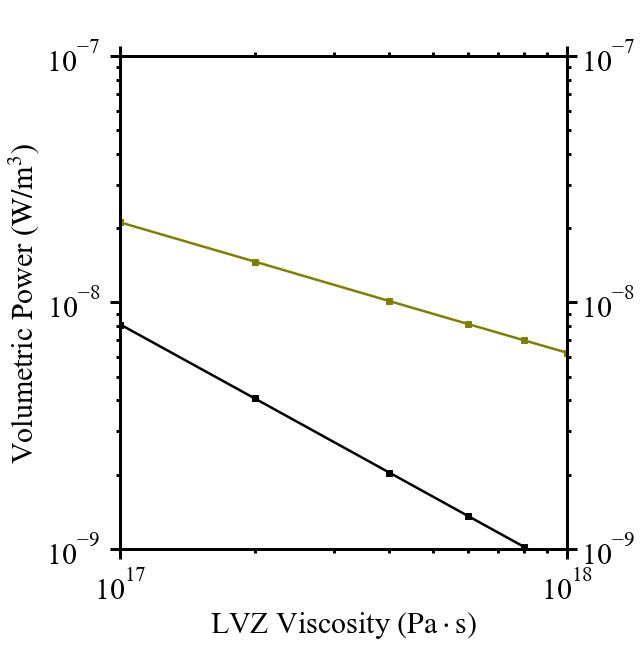

In [1]:
import os
from matplotlib.legend_handler import HandlerTuple
from scipy.interpolate import CubicSpline as CSINTP
from scipy.interpolate import Akima1DInterpolator as AKINTP
import matplotlib.colorbar as CB
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK
import numpy as NP
import numpy.linalg as NPL
import scipy.io 
import scipy.special as SSP
import sympy as SY
import sympy.matrices as SYM
import tool_layerallocation as LA


def temporal_evolution_of_tidal_heating(EM_Distance, model, eta_LVZ=1e17):
    #-----------------------------#
    #Basic Parameters for the Moon#
    #Interior structures:#
    #A liquid core, 340 km#
    #A MIC layer, 400 km#
    #A lunar mantle, 1400 km#
    #-----------------------------#
    Angular_Velocity = 2 * NP.pi / ((EM_Distance/60)**(1.5)*29.530*24*60*60)## a~35 Re at 4.0 Ga, ~60 Re at present. According to Kepler'law, 
    Eccentricity = 0.0549## 4.0 Ga?
    G_Constant = 6.67e-11
    R_c = 340e3
    R_MIC = 640e3 
    R_mantle = 1695e3
    Rs = 1740e3
    Alpha = 0.5 
    Eta = [0.1, eta_LVZ, 1e20, 1e25] 
    Vs = [0.1, 3500, 4500, 4500] 
    Vp = [4000, 7000, 8000, 8000] 
    Rho = [7800, 3450, 3400, 2800] 
    Mu = [x*y**2 for (x,y) in zip(Rho, Vs)]
    Kappa = [x*y**2 - 4*z/3 for (x,y,z) in zip(Rho, Vp, Mu)]
    Layer_Number = 101 ##Innermost layer: #0; Outermost layer: #100. We assume physical properties below are constant in any layer
    nr = [1, 41, 96, 101] ## Changed
    rr = [R_c, R_MIC, R_mantle, Rs]
    Radius = LA.Generation_radius(nr, rr)
    RADIUS = NP.array(Radius, dtype=complex).reshape(-1,1) ## RADIUS[0] is the top radius of Layer #0, i.e., the core, so do other layers. 
    GRAVITY = NP.zeros((Layer_Number,1), dtype=complex) ## GRAVITY is the gravitational acceleration of Layer #0, so do other layers.
    DENSITY = NP.zeros((Layer_Number,1), dtype=complex) ## DENSITY is the density of Layer #0, so do other layers.
    SHEAR_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    LAME_CONSTANT = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    BULK_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## still real number value in the viscoelastic problem
    mu_tmp = 0 ## used to calculate real/imaginary-number-value shear modulus
    sm_real = 0 ## real part of complex shear modulus
    sm_img = 0 ## imaginary part of complex shear modulus
    if model=='Maxwell':
        for layer, radius in enumerate(RADIUS):
            if radius.real <= Radius[0]:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    elif model=='Andrade':
        for layer, radius in enumerate(RADIUS):
            if radius <= R_c:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                SHEAR_MODULUS[layer] = 0 + 0j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                Beta = mu_tmp**(Alpha-1) / eta_tmp**(Alpha) ##3.2e-13
                andrade_cos = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.cos(Alpha*NP.pi/2)
                andrade_sin = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.sin(Alpha*NP.pi/2)
                sm_real = mu_tmp * (1+mu_tmp*andrade_cos) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                sm_img = mu_tmp**2 * (andrade_sin+1/(eta_tmp*Angular_Velocity)) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    #----------------------------------------------------------------------------#
    #Generating Propagator Matrix based on Sabadini, Vermeersen & Cambiotti, 2016#
    #----------------------------------------------------------------------------#
    pgYk = NP.zeros((Layer_Number,6,6), dtype=complex) ## The propagator matrix (type: ndarray), product of k=0 to N-1, do not calculate Layer 0. 
    r = SY.Symbol('r', complex=True)                  ## The shape of ndarray can be >= 3 while the shape of matrix must be 2. 
    g = SY.Symbol('g', complex=True)                  ## Every element of pgYk should be converted to matrix before involved  
    mu = SY.Symbol('mu', complex=True) ## complex number
    rho = SY.Symbol('rho', complex=True)
    Y = SYM.Matrix([[r**3 / 7, r, 0, 1 / (2*r**2), 1 / r**4, 0],
                [5 * r**3 / 42, r / 2, 0, 0, -1 / (3*r**4), 0],
                [(-mu + g*rho*r) *r**2 / 7, 2*mu + g*rho*r, r**2 * rho, (-6*mu + g*rho*r) / (2*r**3), (-8*mu + g*rho*r) / r**5, rho / r**3],
                [8*mu * r**2 / 21, mu, 0, mu / (2*r**3), 8*mu / (3*r**5), 0],
                [0, 0, r**2, 0, 0, 1 / r**3],
                [4*SY.pi*G_Constant*rho*r**3 / 7, 4*SY.pi*G_Constant*rho*r, 5*r, 2*SY.pi*G_Constant*rho / r**2, 4*SY.pi*G_Constant*rho / r**4, 0]])
    D = SYM.diag(3 / r**3, 1 / r, -1 / r, 2*r**2, 3*r**4 / 7, r**3) / 5
    Ybar = SYM.Matrix([[rho * g * r / mu - 8, 16, -r / mu, 2 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 6, -6, r / mu, 0, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho, 0, 0, 0, 0, -1],
                    [rho * g * r / mu + 2, 6, -r / mu, -3 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 1, -16, r / mu, 5 * r / mu, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho * r, 0, 0, 0, 5, -r]])
    invY = D * Ybar ## Y.inv() works, too
    func_Yk = SY.lambdify((r, g, mu, rho), Y, modules='numpy') ## Convert Sympy matrices into Numpy ndarrays (i.e., matrices)
    func_invYk = SY.lambdify((r, g, mu, rho), invY, modules='numpy') ## Ditto
    for k, ite_tmp in enumerate(RADIUS[1:], start=1): ##enumerate will return a tuple, which is immutable. So we directly change the pgYk via index
        if k == 1:
            pgYk[k] = func_invYk(complex(RADIUS[0]), complex(GRAVITY[1]), complex(SHEAR_MODULUS[1]), complex(DENSITY[1]))
            continue
        else:
            Yk_tmp = func_Yk(complex(RADIUS[k-1]), complex(GRAVITY[k-1]), complex(SHEAR_MODULUS[k-1]), complex(DENSITY[k-1]))
            invYk_tmp = func_invYk(complex(RADIUS[k-1]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
            pgYk[k] = invYk_tmp @ Yk_tmp @ pgYk[k-1] ## @ operator is matrix multiplication

    #--------------------------------------#
    #Calculating Interface Matrix#
    #CMB boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    Ic = NP.array([[-Radius[0]**2 / complex(GRAVITY[0]), 0, 1], 
                [0, 1, 0],
                [0, 0, complex(GRAVITY[0]) * complex(DENSITY[0])],
                [0, 0, 0],
                [Radius[0]**2, 0, 0],
                [2 * Radius[0], 0, 4 * NP.pi* G_Constant * complex(DENSITY[0])]], dtype=complex) 

    #--------------------------------------#
    #Solving Cc, the constant vector#
    #Surface boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    P1 = NP.diag(NP.array([0, 0, 1, 1, 0, 1], dtype=complex)) ##Selection Matrix
    Bs = NP.array([[0], [0], [5 / Radius[-1]]], dtype=complex) ##y3=0; y4=0; y6=5/Rs. ##test
    pgY = P1 @ func_Yk(complex(RADIUS[Layer_Number-1]), complex(GRAVITY[Layer_Number-1]), complex(SHEAR_MODULUS[Layer_Number-1]), complex(DENSITY[Layer_Number-1])) @ pgYk[Layer_Number-1] @ Ic
    Cc = NPL.solve(pgY[[2,3,5],:], Bs)

    #-----------------------------------------------------------------------------------------------------#
    #Calculating the vector y#
    #Note: the signs of y1-y4 obtained here are opposite to those in Tobie et al. (2005)#
    #This is because we define the outward radial direction as positive, i.e., tensile stress is positive#
    #while Tobie et al. (2005) consider the inward radia direction as positive, i.e., compress is positive#
    #NNote: In Tobie et al. (2005), y2 represented spheroidal radial stress#
    #and y3 represented spheroidal tangential displacement.#
    #-----------------------------------------------------------------------------------------------------#
    y1 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial displacement
    y2 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential displacement
    y3 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial stress
    y4 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential stress 
    y5 = NP.zeros((Layer_Number,1), dtype=complex) ## potential
    y6 = NP.zeros((Layer_Number,1), dtype=complex) ## potential stress
    for k, radius in enumerate(RADIUS):
        Yk = func_Yk(complex(RADIUS[k]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
        yk = Yk @ pgYk[k] @ Ic @ Cc
        y1[k] = yk[0]
        y2[k] = yk[1]
        y3[k] = yk[2]
        y4[k] = yk[3]
        y5[k] = yk[4]
        y6[k] = yk[5]

    #---------------------------------------------------------#
    #Calculate H_mu and tidal dissipation rate per unit volume#
    #This method works for computating the radial distribution#
    #of the dissipation rate within any planetary interior#
    #according to Kervazo et al., 2021; Tobie et al., 2005#
    #---------------------------------------------------------#
    y_1 = SY.Symbol('y_1', complex=True)
    y_2 = SY.Symbol('y_2', complex=True)
    y_3 = SY.Symbol('y_3', complex=True)
    y_4 = SY.Symbol('y_4', complex=True)
    kappa = SY.Symbol('kappa', complex=True)
    dy_1 = (y_2 - (kappa-2*mu/3)*(2*y_1-6*y_3)/r) / (kappa + 4*mu/3) 
    H_mu_part1 = 4/3 * (r/SY.Abs(kappa+4*mu/3))**2 * (SY.Abs(y_2 - (kappa-2*mu/3)*(2*y_1 - 6*y_3)/r))**2
    H_mu_part2 = -4/3 * r * (dy_1.conjugate()*(2*y_1 - 6*y_3)).as_real_imag()[0]
    H_mu_part3 = 1/3 * (SY.Abs(2*y_1 - 6*y_3))**2 
    H_mu_part4 = 6 * r**2 * (SY.Abs(y_4))**2 / (SY.Abs(mu))**2 
    H_mu_part5 = 24 * (SY.Abs(y_3))**2 
    H_mu = H_mu_part1 + H_mu_part2 + H_mu_part3 + H_mu_part4 + H_mu_part5
    func_Hmu = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r), H_mu, modules='numpy')

    #------------------------------------------------------------#
    #Calculating the tidal dissipation rate#
    #according to Eq. (37) in Tobie et al. (2005)#
    #Note: our y1-y4 are opposite to those of Tobie et al. (2005)#
    #and y2-y3 should exchange #
    #------------------------------------------------------------#
    Hmu = NP.zeros((Layer_Number,1)) 
    h_tide = NP.zeros((Layer_Number,1)) ## tidal dissipation rate, W/m^3
    Volume_MIC = 4/3 * NP.pi * (rr[1]**3 - rr[0]**3)
    Volume_mantle = 4/3 * NP.pi * (rr[2]**3 - rr[1]**3)
    Power_tide_MIC = 0
    Power_tide_mantle = 0
    for k, radius in enumerate(RADIUS):
        if radius.real <= rr[0]:
            continue
        elif radius.real <= rr[1]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_MIC = Power_tide_MIC + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        elif radius.real <= rr[2]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_mantle = Power_tide_mantle + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        else:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag

    return (Power_tide_MIC[0].real/Volume_MIC)

#-----------------------------#
#Basic Parameters for the Moon#
#-----------------------------#
EM_Distance = 35 ## normalized by Re
Viscosity_LVZ = NP.array([1e17, 2e17, 4e17, 6e17, 8e17, 1e18])
h_tide_Andrade = [temporal_evolution_of_tidal_heating(EM_Distance,'Andrade', eta_LVZ) for eta_LVZ in Viscosity_LVZ]
h_tide_Maxwell = [temporal_evolution_of_tidal_heating(EM_Distance,'Maxwell', eta_LVZ) for eta_LVZ in Viscosity_LVZ]

#---------------------------#
#Universal Figure Parameters#
#---------------------------#
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext
fig, ax = PLT.subplots(figsize=(9,9))
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3

Andrade, = ax.plot(Viscosity_LVZ, h_tide_Andrade, linewidth=linewidth_ax, color='olive', linestyle='-', label='Andrade', marker='s') 
Maxwell, = ax.plot(Viscosity_LVZ, h_tide_Maxwell, linewidth=linewidth_ax, color='black', linestyle='-', label='Maxwell', marker='s') 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e17,1e18)
ax.set_ylim(1.0e-9,1.0e-7)
ax.xaxis.set_major_locator(TICK.LogLocator(base=10,numticks =10))
ax.xaxis.set_minor_locator(TICK.LogLocator(base=10.0,subs=NP.arange(2,10)*0.1,numticks =10))
ax.xaxis.set_minor_formatter(TICK.NullFormatter())
ax.tick_params(axis='both',direction='out',length=10,labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
ax.set_xlabel(r"LVZ Viscosity"+" "+r"$\mathrm{(Pa\cdot s)}$",fontsize=labelsize_ax)
ax.set_ylabel(r"Volumetric Power ($\mathrm{W/m^3}$)",fontsize=labelsize_ax)
## top x axis
ax2=ax.twiny()
ax2.set_xscale('log')
ax2.set_xlim(1e17,1e18)
ax2.xaxis.set_major_locator(TICK.LogLocator(base=10,numticks =10))
ax2.xaxis.set_minor_locator(TICK.LogLocator(base=10.0,subs=NP.arange(2,10)*0.1,numticks =10))
ax2.xaxis.set_minor_formatter(TICK.NullFormatter())
ax2.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,labelcolor='none',width=borderwidth_ax)
ax2.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## right y axis
ax3=ax.twinx()
ax3.set_yscale('log')
ax3.set_ylim(1e-9,1.0e-7) 
ax3.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,width=borderwidth_ax)
ax3.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## overall setting
for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_linewidth(borderwidth_ax)

fig.savefig(f"SubFigure_b_TidalPowerVariation_with_Viscosity.pdf",bbox_inches='tight',transparent=True) ##change
PLT.tight_layout()
PLT.show()


### 2c: Andrade, 1e17 Temporal Evolution Comparison

C:\Users\wbzha\AppData\Local\Temp\ipykernel_1224\2390958799.py:217: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
C:\Users\wbzha\AppData\Local\Temp\ipykernel_1224\2390958799.py:223: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
C:\Users\wbzha\AppData\Local\Temp\ipykernel_1224\2390958799.py:229: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


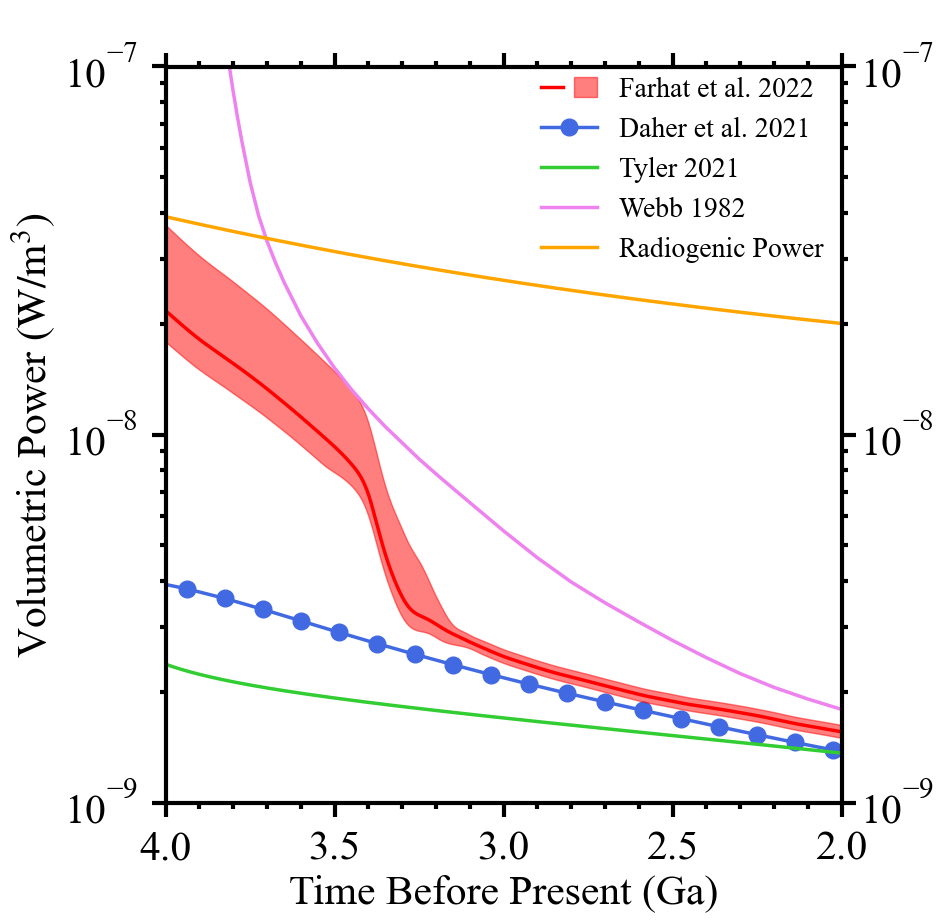

In [13]:
import os
from matplotlib.legend_handler import HandlerTuple
from scipy.interpolate import CubicSpline as CSINTP
from scipy.interpolate import Akima1DInterpolator as AKINTP
import matplotlib.colorbar as CB
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK
import numpy as NP
import numpy.linalg as NPL
import scipy.io 
import scipy.special as SSP
import sympy as SY
import sympy.matrices as SYM
import tool_layerallocation as LA


def temporal_evolution_of_tidal_heating(EM_Distance, model, eta_LVZ=1e17):
    #-----------------------------#
    #Basic Parameters for the Moon#
    #Interior structures:#
    #A liquid core, 340 km#
    #A MIC layer, 400 km#
    #A lunar mantle, 1400 km#
    #-----------------------------#
    Angular_Velocity = 2 * NP.pi / ((EM_Distance/60)**(1.5)*29.530*24*60*60)## a~35 Re at 4.0 Ga, ~60 Re at present. According to Kepler'law, 
    Eccentricity = 0.0549## 4.0 Ga?
    G_Constant = 6.67e-11
    R_c = 340e3
    R_MIC = 640e3 
    R_mantle = 1695e3
    Rs = 1740e3
    Alpha = 0.5 
    Eta = [0.1, eta_LVZ, 1e20, 1e25] 
    Vs = [0.1, 3500, 4500, 4500] 
    Vp = [4000, 7000, 8000, 8000] 
    Rho = [7800, 3440, 3400, 2800] 
    Mu = [x*y**2 for (x,y) in zip(Rho, Vs)]
    Kappa = [x*y**2 - 4*z/3 for (x,y,z) in zip(Rho, Vp, Mu)]
    Layer_Number = 101 ##Innermost layer: #0; Outermost layer: #100. We assume physical properties below are constant in any layer
    nr = [1, 41, 96, 101] ## Changed
    rr = [R_c, R_MIC, R_mantle, Rs]
    Radius = LA.Generation_radius(nr, rr)
    RADIUS = NP.array(Radius, dtype=complex).reshape(-1,1) ## RADIUS[0] is the top radius of Layer #0, i.e., the core, so do other layers. 
    GRAVITY = NP.zeros((Layer_Number,1), dtype=complex) ## GRAVITY is the gravitational acceleration of Layer #0, so do other layers.
    DENSITY = NP.zeros((Layer_Number,1), dtype=complex) ## DENSITY is the density of Layer #0, so do other layers.
    SHEAR_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    LAME_CONSTANT = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    BULK_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## still real number value in the viscoelastic problem
    mu_tmp = 0 ## used to calculate real/imaginary-number-value shear modulus
    sm_real = 0 ## real part of complex shear modulus
    sm_img = 0 ## imaginary part of complex shear modulus
    if model=='Maxwell':
        for layer, radius in enumerate(RADIUS):
            if radius.real <= Radius[0]:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    elif model=='Andrade':
        for layer, radius in enumerate(RADIUS):
            if radius <= R_c:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                SHEAR_MODULUS[layer] = 0 + 0j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                Beta = mu_tmp**(Alpha-1) / eta_tmp**(Alpha) ##3.2e-13
                andrade_cos = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.cos(Alpha*NP.pi/2)
                andrade_sin = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.sin(Alpha*NP.pi/2)
                sm_real = mu_tmp * (1+mu_tmp*andrade_cos) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                sm_img = mu_tmp**2 * (andrade_sin+1/(eta_tmp*Angular_Velocity)) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    #----------------------------------------------------------------------------#
    #Generating Propagator Matrix based on Sabadini, Vermeersen & Cambiotti, 2016#
    #----------------------------------------------------------------------------#
    pgYk = NP.zeros((Layer_Number,6,6), dtype=complex) ## The propagator matrix (type: ndarray), product of k=0 to N-1, do not calculate Layer 0. 
    r = SY.Symbol('r', complex=True)                  ## The shape of ndarray can be >= 3 while the shape of matrix must be 2. 
    g = SY.Symbol('g', complex=True)                  ## Every element of pgYk should be converted to matrix before involved  
    mu = SY.Symbol('mu', complex=True) ## complex number
    rho = SY.Symbol('rho', complex=True)
    Y = SYM.Matrix([[r**3 / 7, r, 0, 1 / (2*r**2), 1 / r**4, 0],
                [5 * r**3 / 42, r / 2, 0, 0, -1 / (3*r**4), 0],
                [(-mu + g*rho*r) *r**2 / 7, 2*mu + g*rho*r, r**2 * rho, (-6*mu + g*rho*r) / (2*r**3), (-8*mu + g*rho*r) / r**5, rho / r**3],
                [8*mu * r**2 / 21, mu, 0, mu / (2*r**3), 8*mu / (3*r**5), 0],
                [0, 0, r**2, 0, 0, 1 / r**3],
                [4*SY.pi*G_Constant*rho*r**3 / 7, 4*SY.pi*G_Constant*rho*r, 5*r, 2*SY.pi*G_Constant*rho / r**2, 4*SY.pi*G_Constant*rho / r**4, 0]])
    D = SYM.diag(3 / r**3, 1 / r, -1 / r, 2*r**2, 3*r**4 / 7, r**3) / 5
    Ybar = SYM.Matrix([[rho * g * r / mu - 8, 16, -r / mu, 2 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 6, -6, r / mu, 0, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho, 0, 0, 0, 0, -1],
                    [rho * g * r / mu + 2, 6, -r / mu, -3 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 1, -16, r / mu, 5 * r / mu, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho * r, 0, 0, 0, 5, -r]])
    invY = D * Ybar ## Y.inv() works, too
    func_Yk = SY.lambdify((r, g, mu, rho), Y, modules='numpy') ## Convert Sympy matrices into Numpy ndarrays (i.e., matrices)
    func_invYk = SY.lambdify((r, g, mu, rho), invY, modules='numpy') ## Ditto
    for k, ite_tmp in enumerate(RADIUS[1:], start=1): ##enumerate will return a tuple, which is immutable. So we directly change the pgYk via index
        if k == 1:
            pgYk[k] = func_invYk(complex(RADIUS[0]), complex(GRAVITY[1]), complex(SHEAR_MODULUS[1]), complex(DENSITY[1]))
            continue
        else:
            Yk_tmp = func_Yk(complex(RADIUS[k-1]), complex(GRAVITY[k-1]), complex(SHEAR_MODULUS[k-1]), complex(DENSITY[k-1]))
            invYk_tmp = func_invYk(complex(RADIUS[k-1]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
            pgYk[k] = invYk_tmp @ Yk_tmp @ pgYk[k-1] ## @ operator is matrix multiplication

    #--------------------------------------#
    #Calculating Interface Matrix#
    #CMB boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    Ic = NP.array([[-Radius[0]**2 / complex(GRAVITY[0]), 0, 1], 
                [0, 1, 0],
                [0, 0, complex(GRAVITY[0]) * complex(DENSITY[0])],
                [0, 0, 0],
                [Radius[0]**2, 0, 0],
                [2 * Radius[0], 0, 4 * NP.pi* G_Constant * complex(DENSITY[0])]], dtype=complex) 

    #--------------------------------------#
    #Solving Cc, the constant vector#
    #Surface boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    P1 = NP.diag(NP.array([0, 0, 1, 1, 0, 1], dtype=complex)) ##Selection Matrix
    Bs = NP.array([[0], [0], [5 / Radius[-1]]], dtype=complex) ##y3=0; y4=0; y6=5/Rs. ##test
    pgY = P1 @ func_Yk(complex(RADIUS[Layer_Number-1]), complex(GRAVITY[Layer_Number-1]), complex(SHEAR_MODULUS[Layer_Number-1]), complex(DENSITY[Layer_Number-1])) @ pgYk[Layer_Number-1] @ Ic
    Cc = NPL.solve(pgY[[2,3,5],:], Bs)

    #-----------------------------------------------------------------------------------------------------#
    #Calculating the vector y#
    #Note: the signs of y1-y4 obtained here are opposite to those in Tobie et al. (2005)#
    #This is because we define the outward radial direction as positive, i.e., tensile stress is positive#
    #while Tobie et al. (2005) consider the inward radia direction as positive, i.e., compress is positive#
    #NNote: In Tobie et al. (2005), y2 represented spheroidal radial stress#
    #and y3 represented spheroidal tangential displacement.#
    #-----------------------------------------------------------------------------------------------------#
    y1 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial displacement
    y2 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential displacement
    y3 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial stress
    y4 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential stress 
    y5 = NP.zeros((Layer_Number,1), dtype=complex) ## potential
    y6 = NP.zeros((Layer_Number,1), dtype=complex) ## potential stress
    for k, radius in enumerate(RADIUS):
        Yk = func_Yk(complex(RADIUS[k]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
        yk = Yk @ pgYk[k] @ Ic @ Cc
        y1[k] = yk[0]
        y2[k] = yk[1]
        y3[k] = yk[2]
        y4[k] = yk[3]
        y5[k] = yk[4]
        y6[k] = yk[5]

    #---------------------------------------------------------#
    #Calculate H_mu and tidal dissipation rate per unit volume#
    #This method works for computating the radial distribution#
    #of the dissipation rate within any planetary interior#
    #according to Kervazo et al., 2021; Tobie et al., 2005#
    #---------------------------------------------------------#
    y_1 = SY.Symbol('y_1', complex=True)
    y_2 = SY.Symbol('y_2', complex=True)
    y_3 = SY.Symbol('y_3', complex=True)
    y_4 = SY.Symbol('y_4', complex=True)
    kappa = SY.Symbol('kappa', complex=True)
    dy_1 = (y_2 - (kappa-2*mu/3)*(2*y_1-6*y_3)/r) / (kappa + 4*mu/3) 
    H_mu_part1 = 4/3 * (r/SY.Abs(kappa+4*mu/3))**2 * (SY.Abs(y_2 - (kappa-2*mu/3)*(2*y_1 - 6*y_3)/r))**2
    H_mu_part2 = -4/3 * r * (dy_1.conjugate()*(2*y_1 - 6*y_3)).as_real_imag()[0]
    H_mu_part3 = 1/3 * (SY.Abs(2*y_1 - 6*y_3))**2 
    H_mu_part4 = 6 * r**2 * (SY.Abs(y_4))**2 / (SY.Abs(mu))**2 
    H_mu_part5 = 24 * (SY.Abs(y_3))**2 
    H_mu = H_mu_part1 + H_mu_part2 + H_mu_part3 + H_mu_part4 + H_mu_part5
    func_Hmu = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r), H_mu, modules='numpy')

    #------------------------------------------------------------#
    #Calculating the tidal dissipation rate#
    #according to Eq. (37) in Tobie et al. (2005)#
    #Note: our y1-y4 are opposite to those of Tobie et al. (2005)#
    #and y2-y3 should exchange #
    #------------------------------------------------------------#
    Hmu = NP.zeros((Layer_Number,1)) 
    h_tide = NP.zeros((Layer_Number,1)) ## tidal dissipation rate, W/m^3
    Volume_MIC = 4/3 * NP.pi * (rr[1]**3 - rr[0]**3)
    Volume_mantle = 4/3 * NP.pi * (rr[2]**3 - rr[1]**3)
    Power_tide_MIC = 0
    Power_tide_mantle = 0
    for k, radius in enumerate(RADIUS):
        if radius.real <= rr[0]:
            continue
        elif radius.real <= rr[1]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_MIC = Power_tide_MIC + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        elif radius.real <= rr[2]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_mantle = Power_tide_mantle + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        else:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag

    return (Power_tide_MIC[0].real/Volume_MIC)

#-----------------------------#
#Basic Parameters for the Moon#
#-----------------------------#
Radius_Earth = 6371e3
Distance_EM = 384400e3
Time_unit = 365 * 24 * 60 * 60 * 1e9
Distance_unit = Distance_EM / Radius_Earth

#----------------------------------------------#
#calculate Webb, 1982#
#https://github.com/trichter/archean_moon_orbit#
#----------------------------------------------#
models = NP.load('Data_From_Eulenfeld&Heubeck/data/orbit_models.npz')
data_Webb = models['Webb 1982 curve d'] ## Time (Ga); Distance (normalized by present-day value)
time_Webb = data_Webb[0]
a_RE_Webb = data_Webb[1] * Distance_unit
h_tide_Andrade_LVZ_Webb = [temporal_evolution_of_tidal_heating(a_RE,'Andrade') for a_RE in a_RE_Webb]

#---------------------------------------------------------------#
#calculate Daher et al., 2021        #
#data interpolation & derivation#
#https://deepblue.lib.umich.edu/data/concern/data_sets/sj1392193#
#---------------------------------------------------------------#
#ocean basin geometries of present-day#
data_PD = scipy.io.loadmat('Data_Daher2021/integration_results_use_Schindelegger_PD_experiments_ode45_nodeLF_v9.mat')
time_PD = data_PD['timestep_vector_PD_ode45'].flatten() / (86400 * 365.25 * 10**9)
a_RE_PD = data_PD['StateVector_PD_ode45'][:, 2] / 6378136
h_tide_Andrade_LVZ_PD = [temporal_evolution_of_tidal_heating(a_RE,'Andrade') for a_RE in a_RE_PD]

#----------------------------------------------#
#calculate Tyler et al., 2021#
#https://github.com/trichter/archean_moon_orbit#
#----------------------------------------------#
data_Tyler_T50 = models['Tyler 2021 T=50']
data_Tyler_T40 = models['Tyler 2021 T=40']
data_Tyler_T30 = models['Tyler 2021 T=30']
#Best-fit values: h=2.3 km and T=40#
a_RE_Tyler2021_40 =  data_Tyler_T40[1]*Distance_unit
h_tide_Andrade_LVZ_40 = [temporal_evolution_of_tidal_heating(a_RE,'Andrade') for a_RE in a_RE_Tyler2021_40]


#------------------------------------#
#calculate Farhat et al., 2022#
#https://www.astrogeo.eu/?page_id=553#
#------------------------------------#
path_data_Farhat = ('Farhat_2022.csv')
data_Farhat = NP.loadtxt(path_data_Farhat, delimiter=',', skiprows=1) 
time_Farhat = data_Farhat[:,0] #Column 0: Ga; 
a_RE_middle = data_Farhat[:,1] #Column 1: a(RE);
a_RE_max = data_Farhat[:,2] #Column 2: amax;
a_RE_min = data_Farhat[:,3] #Column 3: amin

h_tide_Andrade_LVZ_mid = [temporal_evolution_of_tidal_heating(a_RE,'Andrade') for a_RE in a_RE_middle]
h_tide_Andrade_LVZ_max = [temporal_evolution_of_tidal_heating(a_RE,'Andrade') for a_RE in a_RE_min]
h_tide_Andrade_LVZ_min = [temporal_evolution_of_tidal_heating(a_RE,'Andrade') for a_RE in a_RE_max]

#--------------------------------#
#calculate radiogenic heating power#
#based on Taylor&Wieczorek, 2014 #
#--------------------------------#
Rho_mantle = 3400
time_interp_point = NP.linspace(2.0, 4.0, 20) ##
lamda =[9.8458e-10,1.5507e-10,5.5452e-10,4.9511e-11]
H =[5.69e-4,9.46e-5,2.92e-5,2.64e-5] #heat production rate, W/kg   
C =[20.3e-9*0.0071,20.3e-9*0.9928,36.9e-6*1.19e-4,79.5e-9]
HPR_time=(C[0]*H[0]*NP.exp(time_interp_point*lamda[0]*1e9)+C[1]*H[1]*NP.exp(time_interp_point*lamda[1]*1e9) \
                +C[2]*H[2]*NP.exp(time_interp_point*lamda[2]*1e9)+C[3]*H[3]*NP.exp(time_interp_point*lamda[3]*1e9)) ##W/kg
Power_radio = HPR_time * Rho_mantle

#---------------------------#
#Universal Figure Parameters#
#---------------------------#
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext
fig, ax = PLT.subplots(figsize=(9,9))
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3

Webb1982, = ax.plot(time_Webb, h_tide_Andrade_LVZ_Webb, 
                    color='violet', linewidth=linewidth_ax, label="Webb, 1982", linestyle='-', zorder=2)

Daher_PD, = ax.plot(time_PD, h_tide_Andrade_LVZ_PD, color='royalblue', linestyle='-', marker='o',markersize=markersize_ax,
                         linewidth=linewidth_ax, label="Daher et al. 2021", zorder=1)

Tyler2021_40, = ax.plot(data_Tyler_T40[0], h_tide_Andrade_LVZ_40, 
                        color='limegreen', linewidth=linewidth_ax, label="Tyler (2021)", linestyle='-', zorder=2)

middle_line, = ax.plot(time_Farhat, h_tide_Andrade_LVZ_mid, linestyle='-', zorder=2,
                       color='red', linewidth=linewidth_ax, label="Farhat et al. (2022)")

envelope = ax.fill_between(time_Farhat, h_tide_Andrade_LVZ_min, h_tide_Andrade_LVZ_max, color='red', alpha=0.5, zorder=2)

Taylor2014, = ax.plot(time_interp_point, Power_radio, linestyle='-',
                        color='orange', linewidth=linewidth_ax, label="Radiogenic Power")
#------------------------------#
#Universal Figure configuration#
#------------------------------#
ax.set_yscale('log')
ax.set_xlim(4.0,2.0)
ax.set_ylim(1.0e-9,1.0e-7)
ax.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
ax.tick_params(axis='both',direction='out',length=10,labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
ax.set_xlabel(f"Time Before Present (Ga)",fontsize=labelsize_ax)
ax.set_ylabel(r"Volumetric Power ($\mathrm{W/m^3}$)",fontsize=labelsize_ax)
## top x axis
ax2=ax.twiny()
ax2.set_xlim(4.0,2.0)
ax2.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
ax2.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
ax2.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,labelcolor='none',width=borderwidth_ax)
ax2.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## right y axis
ax3=ax.twinx()
ax3.set_yscale('log')
ax3.set_ylim(1e-9,1.0e-7) 
ax3.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,width=borderwidth_ax)
ax3.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## overall setting
for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_linewidth(borderwidth_ax)

handles = [(middle_line, envelope), Daher_PD, Tyler2021_40, Webb1982, Taylor2014]
labels = ['Farhat et al. 2022', 'Daher et al. 2021', 'Tyler 2021', 'Webb 1982', 'Radiogenic Power']
fig.legend(handles, labels, handler_map={tuple: HandlerTuple(ndivide=None)}, 
        bbox_to_anchor=(1.01,1.02),bbox_transform=ax.transAxes,
           edgecolor='none',facecolor='none',fontsize=legendsize_ax)

fig.savefig(f"SubFigure_c_TidalPowerEvolution_Andrade.pdf",bbox_inches='tight',transparent=True) ##change
PLT.tight_layout()
PLT.show()


### 2d: Maxwell, 1e17 Temporal Evolution Comparison

C:\Users\wbzha\AppData\Local\Temp\ipykernel_1224\1701178975.py:217: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
C:\Users\wbzha\AppData\Local\Temp\ipykernel_1224\1701178975.py:223: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
C:\Users\wbzha\AppData\Local\Temp\ipykernel_1224\1701178975.py:229: ComplexWarning: Casting complex values to real discards the imaginary part
  h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag


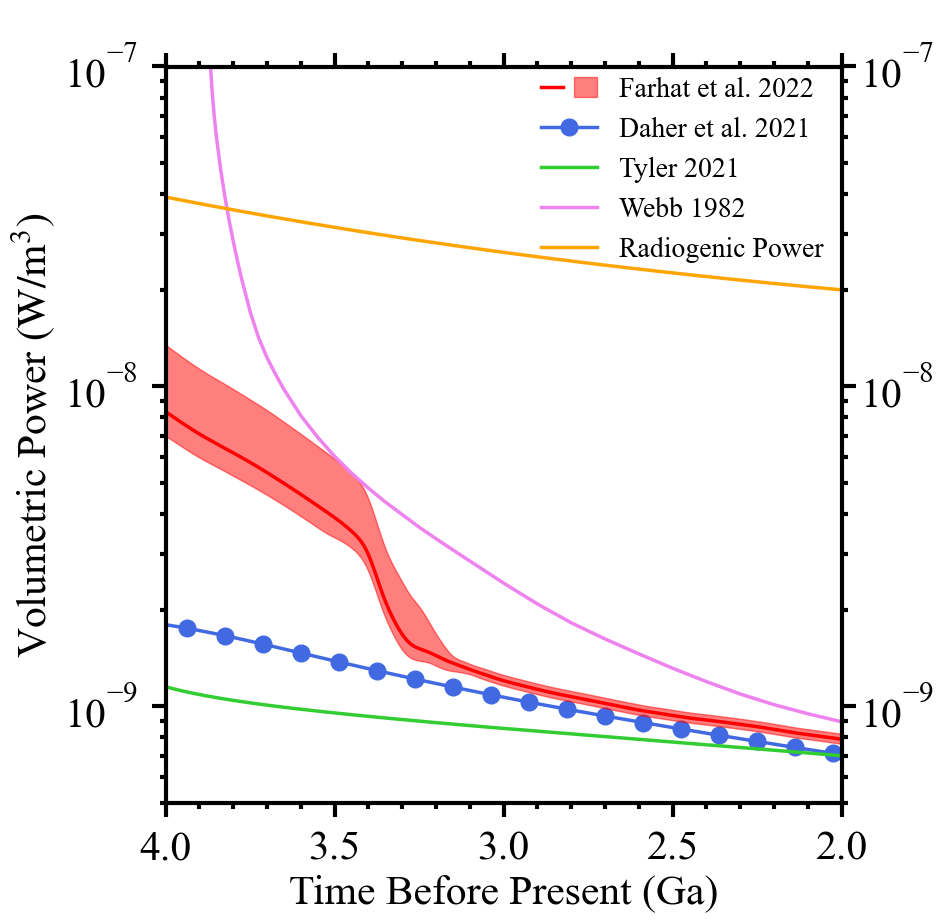

In [14]:
import os
from matplotlib.legend_handler import HandlerTuple
from scipy.interpolate import CubicSpline as CSINTP
from scipy.interpolate import Akima1DInterpolator as AKINTP
import matplotlib.colorbar as CB
import matplotlib.pyplot as PLT
import matplotlib.ticker as TICK
import numpy as NP
import numpy.linalg as NPL
import scipy.io 
import scipy.special as SSP
import sympy as SY
import sympy.matrices as SYM
import tool_layerallocation as LA


def temporal_evolution_of_tidal_heating(EM_Distance, model, eta_LVZ=1e17):
    #-----------------------------#
    #Basic Parameters for the Moon#
    #Interior structures:#
    #A liquid core, 340 km#
    #A MIC layer, 400 km#
    #A lunar mantle, 1400 km#
    #-----------------------------#
    Angular_Velocity = 2 * NP.pi / ((EM_Distance/60)**(1.5)*29.530*24*60*60)## a~35 Re at 4.0 Ga, ~60 Re at present. According to Kepler'law, 
    Eccentricity = 0.0549## 4.0 Ga?
    G_Constant = 6.67e-11
    R_c = 340e3
    R_MIC = 640e3 
    R_mantle = 1695e3
    Rs = 1740e3
    Alpha = 0.5 
    Eta = [0.1, eta_LVZ, 1e20, 1e25] 
    Vs = [0.1, 3500, 4500, 4500] 
    Vp = [4000, 7000, 8000, 8000] 
    Rho = [7800,3440, 3400, 2800] 
    Mu = [x*y**2 for (x,y) in zip(Rho, Vs)]
    Kappa = [x*y**2 - 4*z/3 for (x,y,z) in zip(Rho, Vp, Mu)]
    Layer_Number = 101 ##Innermost layer: #0; Outermost layer: #100. We assume physical properties below are constant in any layer
    nr = [1, 41, 96, 101] ## Changed
    rr = [R_c, R_MIC, R_mantle, Rs]
    Radius = LA.Generation_radius(nr, rr)
    RADIUS = NP.array(Radius, dtype=complex).reshape(-1,1) ## RADIUS[0] is the top radius of Layer #0, i.e., the core, so do other layers. 
    GRAVITY = NP.zeros((Layer_Number,1), dtype=complex) ## GRAVITY is the gravitational acceleration of Layer #0, so do other layers.
    DENSITY = NP.zeros((Layer_Number,1), dtype=complex) ## DENSITY is the density of Layer #0, so do other layers.
    SHEAR_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    LAME_CONSTANT = NP.zeros((Layer_Number,1), dtype=complex) ## complex number value in the viscoelastic problem
    BULK_MODULUS = NP.zeros((Layer_Number,1), dtype=complex) ## still real number value in the viscoelastic problem
    mu_tmp = 0 ## used to calculate real/imaginary-number-value shear modulus
    sm_real = 0 ## real part of complex shear modulus
    sm_img = 0 ## imaginary part of complex shear modulus
    if model=='Maxwell':
        for layer, radius in enumerate(RADIUS):
            if radius.real <= Radius[0]:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                sm_real = mu_tmp * Angular_Velocity**2 * eta_tmp**2 / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                sm_img = mu_tmp**2 * Angular_Velocity * eta_tmp / (mu_tmp**2 + Angular_Velocity**2 * eta_tmp**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    elif model=='Andrade':
        for layer, radius in enumerate(RADIUS):
            if radius <= R_c:
                DENSITY[layer] = Rho[0]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant * Rho[0] * radius
                mu_tmp = Mu[0]
                eta_tmp = Eta[0]
                BULK_MODULUS[layer] = Kappa[0]
                SHEAR_MODULUS[layer] = 0 + 0j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
            else:
                layer_material = LA.Find_MaterialLayer(radius.real, rr)
                DENSITY[layer] = Rho[layer_material]
                GRAVITY[layer] = 4/3*NP.pi*G_Constant*DENSITY[layer]*radius +  GRAVITY[layer-1]*(RADIUS[layer-1]/radius)**2 - 4/3*NP.pi*G_Constant*DENSITY[layer]*RADIUS[layer-1]**3/radius**2 
                mu_tmp = Mu[layer_material]
                eta_tmp = Eta[layer_material]
                BULK_MODULUS[layer] = Kappa[layer_material]
                Beta = mu_tmp**(Alpha-1) / eta_tmp**(Alpha) ##3.2e-13
                andrade_cos = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.cos(Alpha*NP.pi/2)
                andrade_sin = Beta * SSP.gamma(1+Alpha) * Angular_Velocity**(-Alpha) * NP.sin(Alpha*NP.pi/2)
                sm_real = mu_tmp * (1+mu_tmp*andrade_cos) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                sm_img = mu_tmp**2 * (andrade_sin+1/(eta_tmp*Angular_Velocity)) / ((1+mu_tmp*andrade_cos)**2 + mu_tmp**2*(andrade_sin+1/(eta_tmp*Angular_Velocity))**2)
                SHEAR_MODULUS[layer] = sm_real + sm_img * 1j
                LAME_CONSTANT[layer] = BULK_MODULUS[layer] - 2*SHEAR_MODULUS[layer]/3
    #----------------------------------------------------------------------------#
    #Generating Propagator Matrix based on Sabadini, Vermeersen & Cambiotti, 2016#
    #----------------------------------------------------------------------------#
    pgYk = NP.zeros((Layer_Number,6,6), dtype=complex) ## The propagator matrix (type: ndarray), product of k=0 to N-1, do not calculate Layer 0. 
    r = SY.Symbol('r', complex=True)                  ## The shape of ndarray can be >= 3 while the shape of matrix must be 2. 
    g = SY.Symbol('g', complex=True)                  ## Every element of pgYk should be converted to matrix before involved  
    mu = SY.Symbol('mu', complex=True) ## complex number
    rho = SY.Symbol('rho', complex=True)
    Y = SYM.Matrix([[r**3 / 7, r, 0, 1 / (2*r**2), 1 / r**4, 0],
                [5 * r**3 / 42, r / 2, 0, 0, -1 / (3*r**4), 0],
                [(-mu + g*rho*r) *r**2 / 7, 2*mu + g*rho*r, r**2 * rho, (-6*mu + g*rho*r) / (2*r**3), (-8*mu + g*rho*r) / r**5, rho / r**3],
                [8*mu * r**2 / 21, mu, 0, mu / (2*r**3), 8*mu / (3*r**5), 0],
                [0, 0, r**2, 0, 0, 1 / r**3],
                [4*SY.pi*G_Constant*rho*r**3 / 7, 4*SY.pi*G_Constant*rho*r, 5*r, 2*SY.pi*G_Constant*rho / r**2, 4*SY.pi*G_Constant*rho / r**4, 0]])
    D = SYM.diag(3 / r**3, 1 / r, -1 / r, 2*r**2, 3*r**4 / 7, r**3) / 5
    Ybar = SYM.Matrix([[rho * g * r / mu - 8, 16, -r / mu, 2 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 6, -6, r / mu, 0, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho, 0, 0, 0, 0, -1],
                    [rho * g * r / mu + 2, 6, -r / mu, -3 * r / mu, rho * r / mu, 0],
                    [-rho * g * r / mu + 1, -16, r / mu, 5 * r / mu, -rho * r / mu, 0],
                    [4 * SY.pi * G_Constant * rho * r, 0, 0, 0, 5, -r]])
    invY = D * Ybar ## Y.inv() works, too
    func_Yk = SY.lambdify((r, g, mu, rho), Y, modules='numpy') ## Convert Sympy matrices into Numpy ndarrays (i.e., matrices)
    func_invYk = SY.lambdify((r, g, mu, rho), invY, modules='numpy') ## Ditto
    for k, ite_tmp in enumerate(RADIUS[1:], start=1): ##enumerate will return a tuple, which is immutable. So we directly change the pgYk via index
        if k == 1:
            pgYk[k] = func_invYk(complex(RADIUS[0]), complex(GRAVITY[1]), complex(SHEAR_MODULUS[1]), complex(DENSITY[1]))
            continue
        else:
            Yk_tmp = func_Yk(complex(RADIUS[k-1]), complex(GRAVITY[k-1]), complex(SHEAR_MODULUS[k-1]), complex(DENSITY[k-1]))
            invYk_tmp = func_invYk(complex(RADIUS[k-1]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
            pgYk[k] = invYk_tmp @ Yk_tmp @ pgYk[k-1] ## @ operator is matrix multiplication

    #--------------------------------------#
    #Calculating Interface Matrix#
    #CMB boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    Ic = NP.array([[-Radius[0]**2 / complex(GRAVITY[0]), 0, 1], 
                [0, 1, 0],
                [0, 0, complex(GRAVITY[0]) * complex(DENSITY[0])],
                [0, 0, 0],
                [Radius[0]**2, 0, 0],
                [2 * Radius[0], 0, 4 * NP.pi* G_Constant * complex(DENSITY[0])]], dtype=complex) 

    #--------------------------------------#
    #Solving Cc, the constant vector#
    #Surface boundary condition based on#
    #Sabadini, Vermeersen & Cambiotti, 2016#
    #--------------------------------------#
    P1 = NP.diag(NP.array([0, 0, 1, 1, 0, 1], dtype=complex)) ##Selection Matrix
    Bs = NP.array([[0], [0], [5 / Radius[-1]]], dtype=complex) ##y3=0; y4=0; y6=5/Rs. ##test
    pgY = P1 @ func_Yk(complex(RADIUS[Layer_Number-1]), complex(GRAVITY[Layer_Number-1]), complex(SHEAR_MODULUS[Layer_Number-1]), complex(DENSITY[Layer_Number-1])) @ pgYk[Layer_Number-1] @ Ic
    Cc = NPL.solve(pgY[[2,3,5],:], Bs)

    #-----------------------------------------------------------------------------------------------------#
    #Calculating the vector y#
    #Note: the signs of y1-y4 obtained here are opposite to those in Tobie et al. (2005)#
    #This is because we define the outward radial direction as positive, i.e., tensile stress is positive#
    #while Tobie et al. (2005) consider the inward radia direction as positive, i.e., compress is positive#
    #NNote: In Tobie et al. (2005), y2 represented spheroidal radial stress#
    #and y3 represented spheroidal tangential displacement.#
    #-----------------------------------------------------------------------------------------------------#
    y1 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial displacement
    y2 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential displacement
    y3 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal radial stress
    y4 = NP.zeros((Layer_Number,1), dtype=complex) ## spheroidal tangential stress 
    y5 = NP.zeros((Layer_Number,1), dtype=complex) ## potential
    y6 = NP.zeros((Layer_Number,1), dtype=complex) ## potential stress
    for k, radius in enumerate(RADIUS):
        Yk = func_Yk(complex(RADIUS[k]), complex(GRAVITY[k]), complex(SHEAR_MODULUS[k]), complex(DENSITY[k]))
        yk = Yk @ pgYk[k] @ Ic @ Cc
        y1[k] = yk[0]
        y2[k] = yk[1]
        y3[k] = yk[2]
        y4[k] = yk[3]
        y5[k] = yk[4]
        y6[k] = yk[5]

    #---------------------------------------------------------#
    #Calculate H_mu and tidal dissipation rate per unit volume#
    #This method works for computating the radial distribution#
    #of the dissipation rate within any planetary interior#
    #according to Kervazo et al., 2021; Tobie et al., 2005#
    #---------------------------------------------------------#
    y_1 = SY.Symbol('y_1', complex=True)
    y_2 = SY.Symbol('y_2', complex=True)
    y_3 = SY.Symbol('y_3', complex=True)
    y_4 = SY.Symbol('y_4', complex=True)
    kappa = SY.Symbol('kappa', complex=True)
    dy_1 = (y_2 - (kappa-2*mu/3)*(2*y_1-6*y_3)/r) / (kappa + 4*mu/3) 
    H_mu_part1 = 4/3 * (r/SY.Abs(kappa+4*mu/3))**2 * (SY.Abs(y_2 - (kappa-2*mu/3)*(2*y_1 - 6*y_3)/r))**2
    H_mu_part2 = -4/3 * r * (dy_1.conjugate()*(2*y_1 - 6*y_3)).as_real_imag()[0]
    H_mu_part3 = 1/3 * (SY.Abs(2*y_1 - 6*y_3))**2 
    H_mu_part4 = 6 * r**2 * (SY.Abs(y_4))**2 / (SY.Abs(mu))**2 
    H_mu_part5 = 24 * (SY.Abs(y_3))**2 
    H_mu = H_mu_part1 + H_mu_part2 + H_mu_part3 + H_mu_part4 + H_mu_part5
    func_Hmu = SY.lambdify((y_1, y_2, y_3, y_4, mu, kappa, r), H_mu, modules='numpy')

    #------------------------------------------------------------#
    #Calculating the tidal dissipation rate#
    #according to Eq. (37) in Tobie et al. (2005)#
    #Note: our y1-y4 are opposite to those of Tobie et al. (2005)#
    #and y2-y3 should exchange #
    #------------------------------------------------------------#
    Hmu = NP.zeros((Layer_Number,1)) 
    h_tide = NP.zeros((Layer_Number,1)) ## tidal dissipation rate, W/m^3
    Volume_MIC = 4/3 * NP.pi * (rr[1]**3 - rr[0]**3)
    Volume_mantle = 4/3 * NP.pi * (rr[2]**3 - rr[1]**3)
    Power_tide_MIC = 0
    Power_tide_mantle = 0
    for k, radius in enumerate(RADIUS):
        if radius.real <= rr[0]:
            continue
        elif radius.real <= rr[1]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_MIC = Power_tide_MIC + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        elif radius.real <= rr[2]:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag
            Power_tide_mantle = Power_tide_mantle + 4/3*NP.pi * (radius**3 - RADIUS[k-1]**3) * h_tide[k]
        else:
            Hmuk = func_Hmu(complex(-y1[k]), complex(-y3[k]), complex(-y2[k]), complex(-y4[k]), 
                            complex(SHEAR_MODULUS[k]), complex(BULK_MODULUS[k]), complex(radius))
            Hmu[k] = Hmuk.real
            h_tide[k] = 21/10 * Angular_Velocity**5 * Rs**4 * Eccentricity**2 / radius**2 * Hmu[k] * SHEAR_MODULUS[k].imag

    return (Power_tide_MIC[0].real/Volume_MIC)

#-----------------------------#
#Basic Parameters for the Moon#
#-----------------------------#
Radius_Earth = 6371e3
Distance_EM = 384400e3
Time_unit = 365 * 24 * 60 * 60 * 1e9
Distance_unit = Distance_EM / Radius_Earth

#----------------------------------------------#
#calculate Webb, 1982#
#https://github.com/trichter/archean_moon_orbit#
#----------------------------------------------#
models = NP.load('Data_From_Eulenfeld&Heubeck/data/orbit_models.npz')
data_Webb = models['Webb 1982 curve d'] ## Time (Ga); Distance (normalized by present-day value)
time_Webb = data_Webb[0]
a_RE_Webb = data_Webb[1] * Distance_unit
h_tide_Andrade_LVZ_Webb = [temporal_evolution_of_tidal_heating(a_RE,'Maxwell') for a_RE in a_RE_Webb]

#---------------------------------------------------------------#
#calculate Daher et al., 2021        #
#data interpolation & derivation#
#https://deepblue.lib.umich.edu/data/concern/data_sets/sj1392193#
#---------------------------------------------------------------#
#ocean basin geometries of present-day#
data_PD = scipy.io.loadmat('Data_Daher2021/integration_results_use_Schindelegger_PD_experiments_ode45_nodeLF_v9.mat')
time_PD = data_PD['timestep_vector_PD_ode45'].flatten() / (86400 * 365.25 * 10**9)
a_RE_PD = data_PD['StateVector_PD_ode45'][:, 2] / 6378136
h_tide_Andrade_LVZ_PD = [temporal_evolution_of_tidal_heating(a_RE,'Maxwell') for a_RE in a_RE_PD]

#----------------------------------------------#
#calculate Tyler et al., 2021#
#https://github.com/trichter/archean_moon_orbit#
#----------------------------------------------#
data_Tyler_T50 = models['Tyler 2021 T=50']
data_Tyler_T40 = models['Tyler 2021 T=40']
data_Tyler_T30 = models['Tyler 2021 T=30']
#Best-fit values: h=2.3 km and T=40#
a_RE_Tyler2021_40 =  data_Tyler_T40[1]*Distance_unit
h_tide_Andrade_LVZ_40 = [temporal_evolution_of_tidal_heating(a_RE,'Maxwell') for a_RE in a_RE_Tyler2021_40]


#------------------------------------#
#calculate Farhat et al., 2022#
#https://www.astrogeo.eu/?page_id=553#
#------------------------------------#
path_data_Farhat = ('Farhat_2022.csv')
data_Farhat = NP.loadtxt(path_data_Farhat, delimiter=',', skiprows=1) 
time_Farhat = data_Farhat[:,0] #Column 0: Ga; 
a_RE_middle = data_Farhat[:,1] #Column 1: a(RE);
a_RE_max = data_Farhat[:,2] #Column 2: amax;
a_RE_min = data_Farhat[:,3] #Column 3: amin

h_tide_Andrade_LVZ_mid = [temporal_evolution_of_tidal_heating(a_RE,'Maxwell') for a_RE in a_RE_middle]
h_tide_Andrade_LVZ_max = [temporal_evolution_of_tidal_heating(a_RE,'Maxwell') for a_RE in a_RE_min]
h_tide_Andrade_LVZ_min = [temporal_evolution_of_tidal_heating(a_RE,'Maxwell') for a_RE in a_RE_max]

#--------------------------------#
#calculate radiogenic heating power#
#based on Taylor&Wieczorek, 2014 #
#--------------------------------#
Rho_mantle = 3400
time_interp_point = NP.linspace(2.0, 4.0, 20) ##
lamda =[9.8458e-10,1.5507e-10,5.5452e-10,4.9511e-11]
H =[5.69e-4,9.46e-5,2.92e-5,2.64e-5] #heat production rate, W/kg   
C =[20.3e-9*0.0071,20.3e-9*0.9928,36.9e-6*1.19e-4,79.5e-9]
HPR_time=(C[0]*H[0]*NP.exp(time_interp_point*lamda[0]*1e9)+C[1]*H[1]*NP.exp(time_interp_point*lamda[1]*1e9) \
                +C[2]*H[2]*NP.exp(time_interp_point*lamda[2]*1e9)+C[3]*H[3]*NP.exp(time_interp_point*lamda[3]*1e9)) ##W/kg
Power_radio = HPR_time * Rho_mantle

#---------------------------#
#Universal Figure Parameters#
#---------------------------#
PLT.rcParams['font.family'] = 'serif' ##rc: runtime configuration
PLT.rcParams['font.serif'] = ['Times New Roman']
PLT.rcParams['mathtext.fontset'] = 'stix' ##Times-like font used in mathtext
fig, ax = PLT.subplots(figsize=(9,9))
labelsize_ax = 30
ticksize_ax = 30
legendsize_ax = 20
textsize_ax = 30
linewidth_ax = 2.5
markersize_ax = 12
borderwidth_ax = 3

Webb1982, = ax.plot(time_Webb, h_tide_Andrade_LVZ_Webb, 
                    color='violet', linewidth=linewidth_ax, label="Webb, 1982", linestyle='-', zorder=2)

Daher_PD, = ax.plot(time_PD, h_tide_Andrade_LVZ_PD, color='royalblue', linestyle='-', marker='o',markersize=markersize_ax,
                         linewidth=linewidth_ax, label="Daher et al. 2021", zorder=1)

Tyler2021_40, = ax.plot(data_Tyler_T40[0], h_tide_Andrade_LVZ_40, 
                        color='limegreen', linewidth=linewidth_ax, label="Tyler (2021)", linestyle='-', zorder=2)

middle_line, = ax.plot(time_Farhat, h_tide_Andrade_LVZ_mid, linestyle='-', zorder=2,
                       color='red', linewidth=linewidth_ax, label="Farhat et al. (2022)")

envelope = ax.fill_between(time_Farhat, h_tide_Andrade_LVZ_min, h_tide_Andrade_LVZ_max, color='red', alpha=0.5, zorder=2)

Taylor2014, = ax.plot(time_interp_point, Power_radio, linestyle='-',
                        color='orange', linewidth=linewidth_ax, label="Radiogenic Power")
#------------------------------#
#Universal Figure configuration#
#------------------------------#
ax.set_yscale('log')
ax.set_xlim(4.0,2.0)
ax.set_ylim(5.0e-10,1.0e-7)
ax.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
ax.tick_params(axis='both',direction='out',length=10,labelsize=ticksize_ax,pad=10,which='both',width=borderwidth_ax)
ax.tick_params(axis='both',direction='out',length=4,labelsize=ticksize_ax,which='minor',width=borderwidth_ax)
ax.set_xlabel(f"Time Before Present (Ga)",fontsize=labelsize_ax)
ax.set_ylabel(r"Volumetric Power ($\mathrm{W/m^3}$)",fontsize=labelsize_ax)
## top x axis
ax2=ax.twiny()
ax2.set_xlim(4.0,2.0)
ax2.xaxis.set_major_locator(TICK.MultipleLocator(0.5))
ax2.xaxis.set_minor_locator(TICK.MultipleLocator(0.1))
ax2.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,labelcolor='none',width=borderwidth_ax)
ax2.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## right y axis
ax3=ax.twinx()
ax3.set_yscale('log')
ax3.set_ylim(5e-10,1.0e-7) 
ax3.tick_params(axis='both',direction='out',which='both',length=10,labelsize=ticksize_ax,width=borderwidth_ax)
ax3.tick_params(axis='both',direction='out',which='minor',length=4,labelsize=ticksize_ax,width=borderwidth_ax) ##necessary
## overall setting
for border in ['top', 'bottom', 'left', 'right']:
    ax.spines[border].set_linewidth(borderwidth_ax)

fig.savefig(f"SubFigure_d_TidalPowerEvolution_Maxwell.pdf",bbox_inches='tight',transparent=True) ##change
PLT.tight_layout()
PLT.show()